In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'  # (Windows 용) 한글 출력을 위한 글꼴 설정
plt.rcParams['axes.unicode_minus'] = False    # 문자 - (마이너스) 정상 출력을 위한 코드

#실수 설정 옵션 (소수 둘째 짜리까지)
pd.options.display.float_format = '{:.3f}'.format

In [2]:
#한글 폰트 깨짐 방지
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get update -qq
        !apt-get install fonts-nanum -qq  > /dev/null
        import matplotlib.font_manager as fm
        fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font = fm.FontProperties(fname=fontpath, size=9)
        fm._rebuild()
        font_family = "NanumBarunGothic"
    return font_family
get_font_family()
font_family = get_font_family()
# 폰트설정
plt.rc('font', family=font_family)
# 마이너스폰트 설정
plt.rc('axes', unicode_minus=False)

In [4]:
np.random.seed(42)

In [9]:
df_modu = pd.read_csv('./모두컴퍼니_기술과제/실전db.csv')
df_trafic = pd.read_csv('./모두컴퍼니_기술과제/교통량통합.csv',encoding='ansi')
df_weather = pd.read_csv('./모두컴퍼니_기술과제/서울시_기상데이터.csv',encoding = 'cp949')
df_weatherapi = pd.read_csv('weather_day.csv', encoding ='cp949')
df_dust = pd.read_csv('일별평균대기오염도_2020.csv', encoding = 'cp949') 

In [10]:
df_dust=df_dust[['측정일시','초미세먼지(㎍/㎥)']]

#문자형 변환
df_dust['측정일시']=df_dust['측정일시'].astype('str')

In [11]:
df_dust['측정일시'] = pd.to_datetime(df_dust['측정일시'])

df_dust['측정일시']=df_dust['측정일시'].astype('str')

In [12]:
#이름 재배치
name = ['DATE', 'DUST']
df_dust =df_dust.rename(columns = dict(zip(df_dust.columns, name)))

In [13]:
#미세먼지 평균
df_dust2=df_dust.groupby(['DATE']).mean()

df_modu = pd.merge(df_modu,df_dust2, how='outer',on='DATE')

In [14]:
df_modu['DUST'].fillna(method = 'pad', inplace = True)


df_modu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879271 entries, 0 to 879270
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   USER_ID     879271 non-null  int64  
 1   JOIN_DATE   879271 non-null  object 
 2   D_TYPE      879271 non-null  object 
 3   STORE_ID    879271 non-null  int64  
 4   GOODS_TYPE  879271 non-null  object 
 5   DATE        879271 non-null  object 
 6   COUNT       879271 non-null  int64  
 7   AD1         879271 non-null  object 
 8   DUST        879271 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 67.1+ MB


In [15]:
df_modu['DATE']=pd.to_datetime(df_modu['DATE'])
df_trafic['DATE'] = pd.to_datetime(df_trafic['DATE'])

ndata = pd.merge(df_modu,df_trafic, how='left', left_on='DATE', right_on='DATE')

In [35]:
from sklearn import preprocessing

ndata[['합계']] = preprocessing.MinMaxScaler().fit(ndata[['합계']]).transform(ndata[['합계']])

le = preprocessing.LabelEncoder()

ndata['D_TYPE'] = le.fit_transform(ndata['D_TYPE'])
ndata['GOODS_TYPE'] = le.fit_transform(ndata['GOODS_TYPE'])
ndata['AD1'] = le.fit_transform(ndata['AD1'])

In [11]:
u_ndata = ndata['USER_ID'].value_counts().to_frame()
u_ndata.reset_index(inplace = True)
u_ndata.columns = ['USER_ID','결제건수']
ndata = pd.merge(ndata, u_ndata, how='left', left_on='USER_ID', right_on='USER_ID')

In [12]:
ndata['Month'] = [k for k in ndata['DATE'].dt.month]
ndata['Day'] = [k for k in ndata['DATE'].dt.day]
ndata['dayofweek'] = [k for k in ndata['DATE'].dt.dayofweek]

In [13]:
# # 2020년 holiday 지정
# import pandas as pd
# from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday

# class Calendar(AbstractHolidayCalendar):
#     rules = [
#         Holiday('New Year', month=1, day=1),
#         Holiday('KR_New Year1', month=1, day=24),
#         Holiday('KR_New Year2', month=1, day=25),
#         Holiday('KR_New Year3', month=1, day=26),
#         Holiday('3.1', month=3, day=1),
#         Holiday('Buddha Day', month=4, day=30),
#         Holiday('Memorial Day', month=6, day=6),
#         Holiday('Liberation Day', month=8, day=15),
#         Holiday('KR_Thanksgiving1', month=9, day=30),
#         Holiday('KR_Thanksgiving2', month=10, day=1),
#         Holiday('KR_Thanksgiving3', month=10, day=2),
#         Holiday('National Foundation Day', month=10, day=3),
#         Holiday('Hangul Day', month=10, day=9),
#         Holiday('Christmas', month=12, day=25)
#     ]
# dr = pd.date_range(start='2020-01-01', end='2020-12-31')
# cal = Calendar()
# holidays = cal.holidays(start=dr.min(), end=dr.max())
# ndata['Holiday'] = ndata['DATE'].isin(holidays)

# # 일요일도 holiday로
# for i in range(len(ndata)):
#     if ndata['Day'][i] == 6:
#         ndata['Holiday'][i] = True

In [14]:
# ndata['Weekend_indi'] = 0
# ndata['EveryDay'] = ndata.loc[ndata['Day'].isin([4,5]), 'Weekend_indi'] =1

In [16]:
ndata.drop(['USER_ID','JOIN_DATE','STORE_ID'],axis=1,inplace=True)

In [17]:
ndata

,D_TYPE,GOODS_TYPE,DATE,COUNT,AD1,DUST,합계,결제건수,Month,Day,dayofweek
0,0,0,2020-01-01,1,40,22.156,0.361,1,1,1,2
1,1,0,2020-01-01,1,50,22.156,0.361,2,1,1,2
2,1,0,2020-01-01,1,64,22.156,0.361,3,1,1,2
3,1,2,2020-01-01,1,53,22.156,0.361,30,1,1,2
4,0,2,2020-01-01,1,52,22.156,0.361,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
879266,1,1,2020-12-31,1,40,11.080,0.564,1,12,31,3
879267,1,1,2020-12-31,1,19,11.080,0.564,1,12,31,3
879268,0,1,2020-12-31,1,52,11.080,0.564,1,12,31,3
879269,1,1,2020-12-31,1,50,11.080,0.564,1,12,31,3


In [18]:
# 날짜로 자르기 위해 'DATE'를 인덱스로 설정
ndata.set_index('DATE',inplace=True)

# 데이터 분리
train = ndata.loc[:'2020-09-30']
test = ndata.loc['2020-10-01':]

# 인덱스 리셋 후 'DATE' 컬럼 삭제
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [19]:
train_X = train.drop('COUNT',axis=1)
train_y = train[['COUNT']]

test_X = test.drop('COUNT',axis=1)
test_y = test[['COUNT']]

In [20]:
display(train_X, test_X)

,D_TYPE,GOODS_TYPE,AD1,DUST,합계,결제건수,Month,Day,dayofweek
0,0,0,40,22.156,0.361,1,1,1,2
1,1,0,50,22.156,0.361,2,1,1,2
2,1,0,64,22.156,0.361,3,1,1,2
3,1,2,53,22.156,0.361,30,1,1,2
4,0,2,52,22.156,0.361,3,1,1,2
...,...,...,...,...,...,...,...,...,...
623574,1,1,40,19.087,0.316,4,9,30,2
623575,0,1,53,19.087,0.316,1,9,30,2
623576,0,1,4,19.087,0.316,1,9,30,2
623577,1,0,52,19.087,0.316,1,9,30,2


,D_TYPE,GOODS_TYPE,AD1,DUST,합계,결제건수,Month,Day,dayofweek
0,0,0,52,10.522,0.264,1,10,1,3
1,1,3,50,10.522,0.264,2,10,1,3
2,1,0,52,10.522,0.264,2,10,1,3
3,1,0,22,10.522,0.264,10,10,1,3
4,0,0,65,10.522,0.264,2,10,1,3
...,...,...,...,...,...,...,...,...,...
255687,1,1,40,11.080,0.564,1,12,31,3
255688,1,1,19,11.080,0.564,1,12,31,3
255689,0,1,52,11.080,0.564,1,12,31,3
255690,1,1,50,11.080,0.564,1,12,31,3


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

rfr = RandomForestRegressor()
    
rfr.fit(train_X, train_y)
    
y_pred = rfr.predict(test_X)

MSE = mean_squared_error(test_y, y_pred)
MAE = mean_absolute_error(test_y, y_pred)
print('MSE :', MSE)
print('MAE :', MAE)

C:\Users\82102\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


MSE : 0.10035608324770443
MAE : 0.057175932240516904


In [24]:
from lightgbm import LGBMRegressor

lgbr = LGBMRegressor(n_estimators=400) # 트리 수 지정

lgbr.fit(train_X, train_y)

y_pred2 = lgbr.predict(test_X)

MSE = mean_squared_error(test_y, y_pred2)
MAE = mean_absolute_error(test_y, y_pred2)
print('MSE :', MSE)
print('MAE :', MAE)

MSE : 0.09259349669264802
MAE : 0.04706370414187222


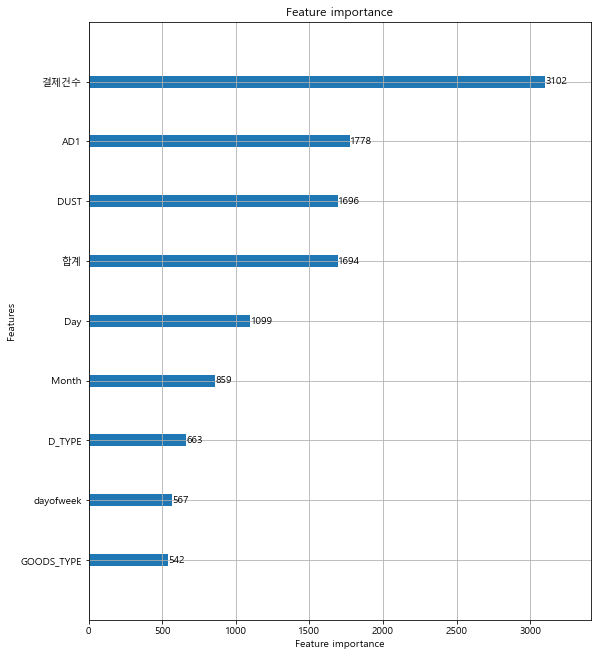

In [23]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(9,11))
plot_importance(lgbr, ax=ax)
plt.savefig('변수의 중요도.png')

In [26]:
!pip install xgboost

In [27]:
import xgboost
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score



In [28]:
xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

lgbr = LGBMRegressor(n_estimators=400) # 트리 수 지정

xgb_model.fit(train_X, train_y)

y_pred3 = xgb_model.predict(test_X)

MSE = mean_squared_error(test_y, y_pred3)
MAE = mean_absolute_error(test_y, y_pred3)
print('MSE :', MSE)
print('MAE :', MAE)

C:\Users\82102\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


MSE : 0.10434001103887557
MAE : 0.04756613377565444


## 교통량과 count 관계

In [16]:
ndata

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,DUST,합계
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,22.156,7347299.000
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,22.156,7347299.000
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,22.156,7347299.000
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,22.156,7347299.000
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,22.156,7347299.000
...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,11.080,8324393.000
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,11.080,8324393.000
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,11.080,8324393.000
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,11.080,8324393.000


In [17]:
pd.crosstab(ndata['합계'], ndata['COUNT'], 
           margins = True).style.background_gradient(cmap = 'cool')

In [78]:
ndata[['합계','COUNT']].groupby(['합계'], as_index= True).count()

,COUNT
합계,
5606406.000,1254
5750066.000,1271
6015681.000,1433
6116596.000,1506
6148809.000,854
...,...
10303512.000,2315
10345004.000,2802
10389367.000,1941


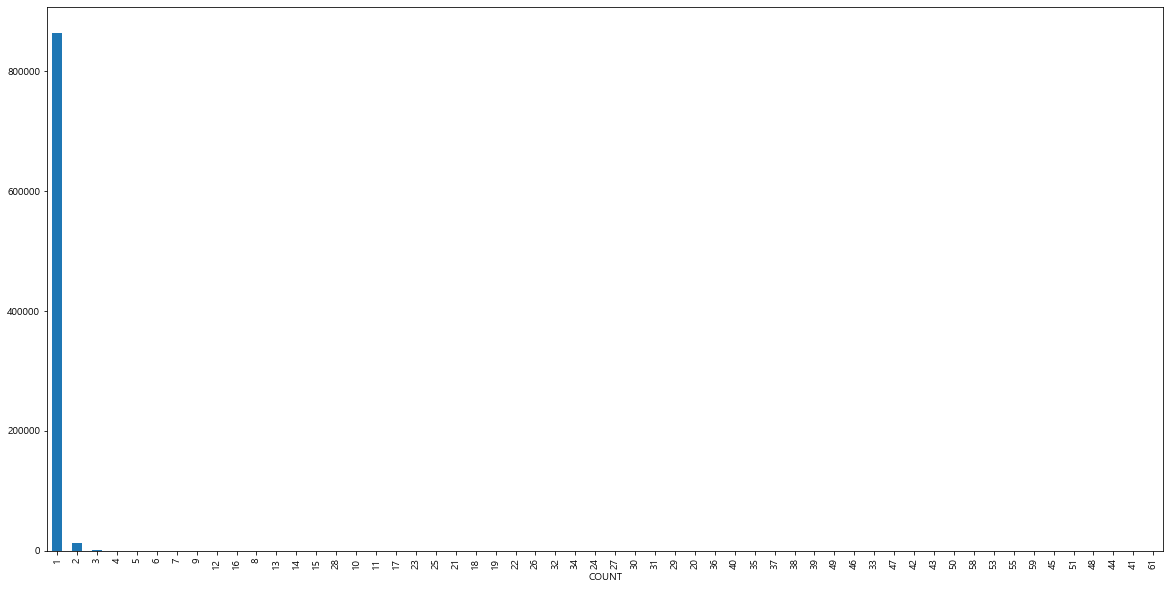

In [18]:
trafic_count = ndata.groupby('COUNT').count()['합계'].sort_values(ascending=False).plot.bar(figsize=(20,10))

C:\Users\82102\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54633 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\82102\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\82102\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\82102\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 54633 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\82102\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\82102\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48324 missing from curre

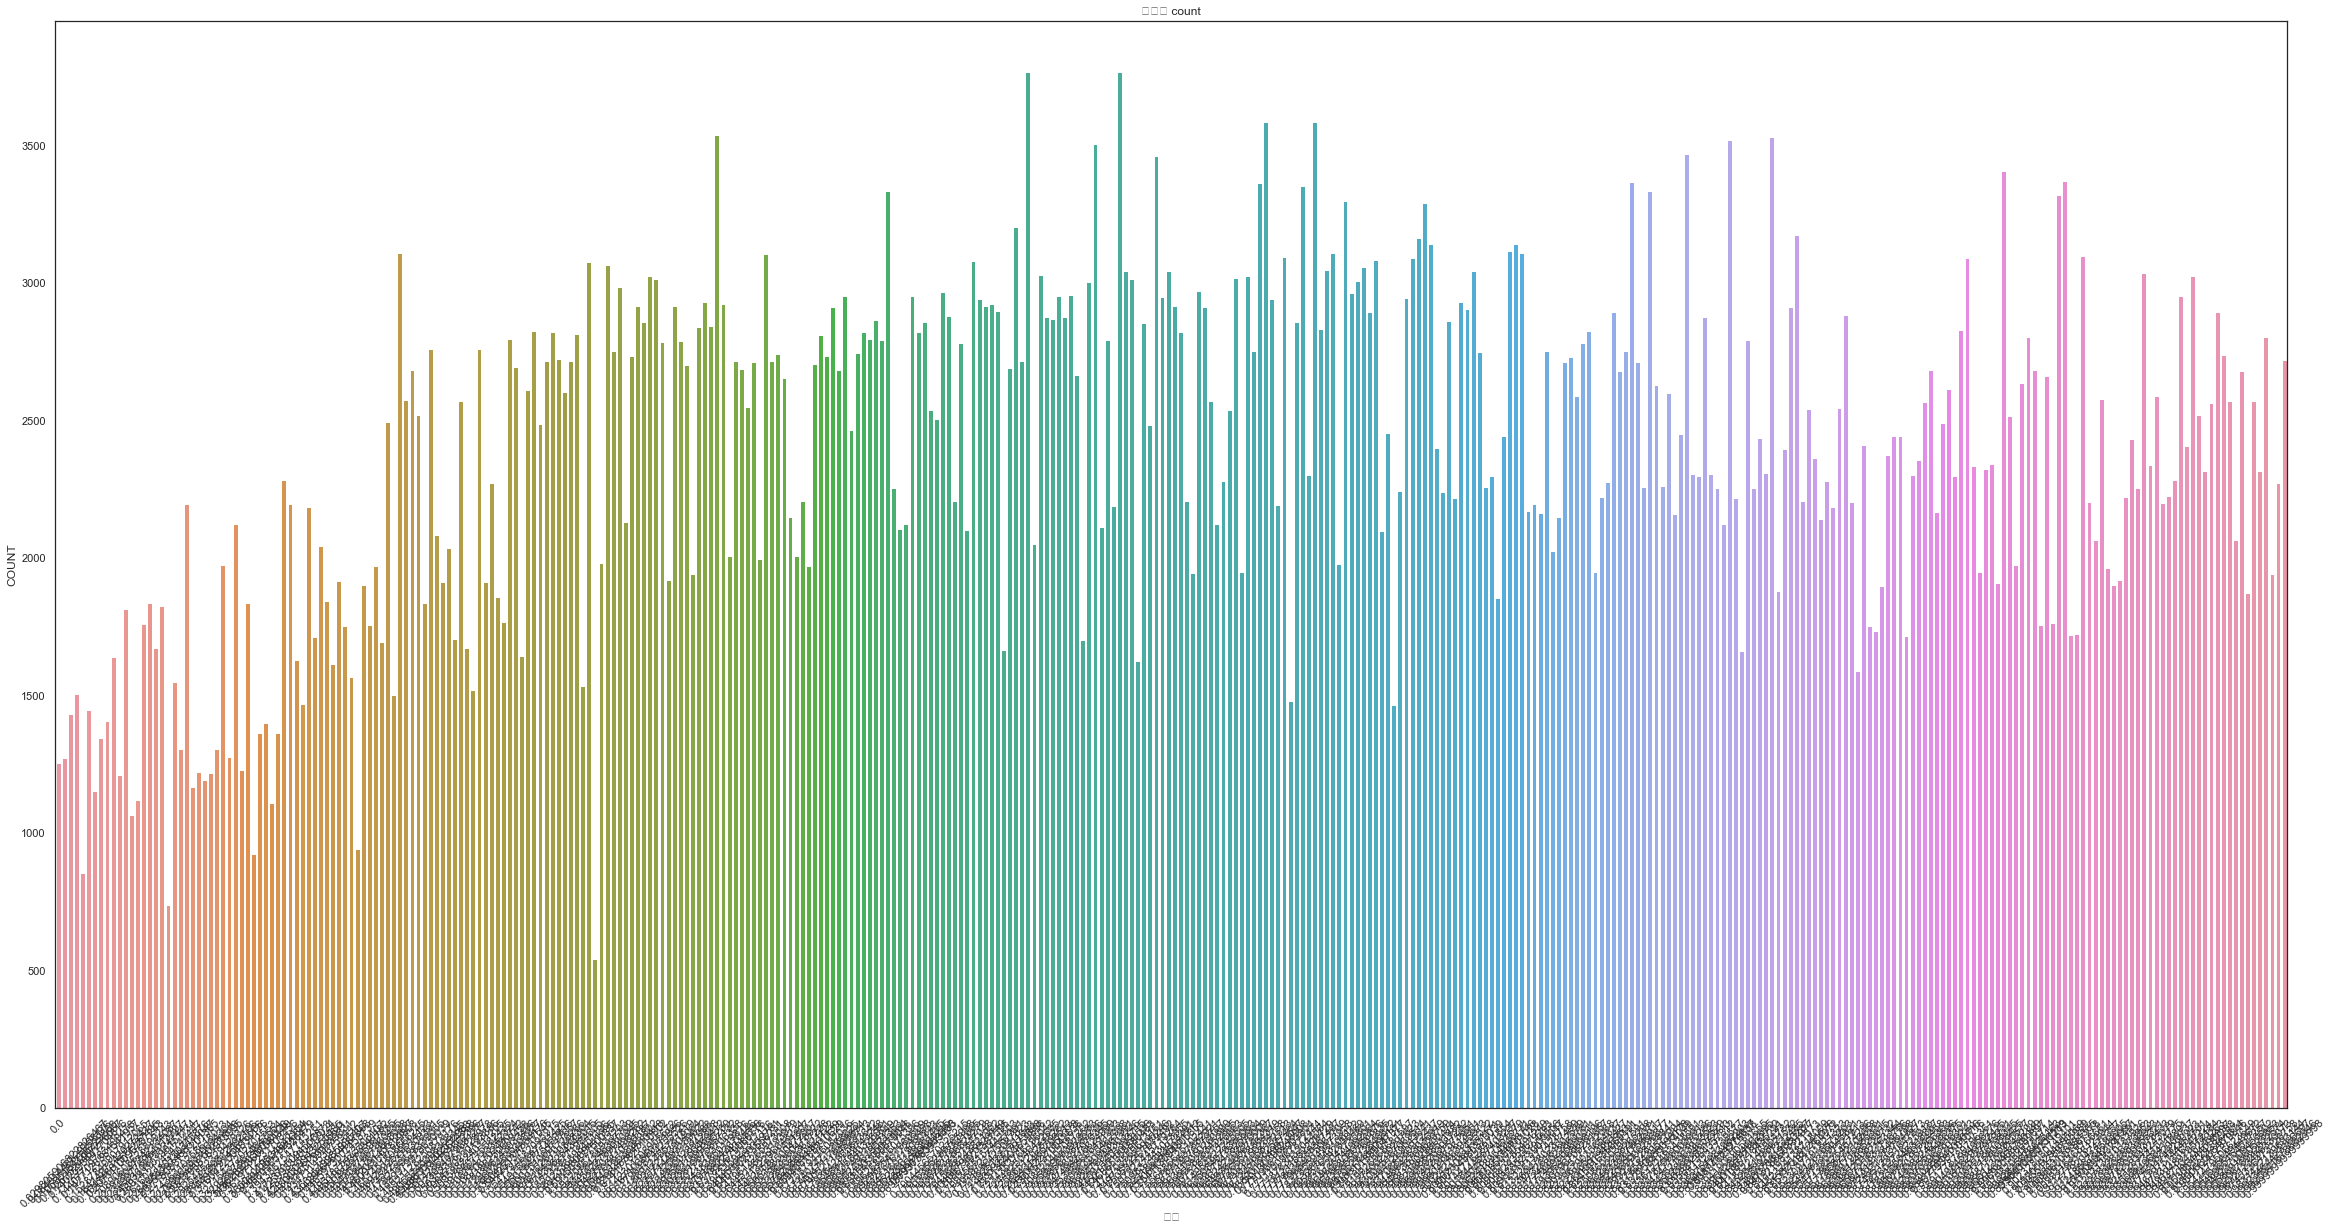

In [60]:
f, axs = plt.subplots(1,1, figsize = (40,20))
sns.barplot(data = ndata, x = '합계',y = 'COUNT',estimator =len)
plt.xticks(rotation =45)
plt.title('합계별 count')
plt.show()

- 이게 뭘까..

In [19]:
df_modu = pd.read_csv('./모두컴퍼니_기술과제/실전db.csv')
df_trafic = pd.read_csv('./모두컴퍼니_기술과제/교통량통합.csv',encoding='ansi')

In [20]:
df_modu['DATE']=pd.to_datetime(df_modu['DATE'])
df_trafic['DATE'] = pd.to_datetime(df_trafic['DATE'])

df_morafic = pd.merge(df_modu,df_trafic, how='left', left_on='DATE', right_on='DATE')

In [37]:
df_moraficm=df_morafic[['합계', 'COUNT','DATE']].groupby(['DATE'], as_index = True).mean()
df_modura2 = ndata[['합계', 'COUNT','DATE']].groupby(['DATE'], as_index = True).mean()

In [38]:
df_modura2

,합계,COUNT
DATE,,
2020-01-01,0.361,1.012
2020-01-02,0.772,1.027
2020-01-03,0.911,1.020
2020-01-04,0.745,1.026
2020-01-05,0.469,1.021
...,...,...
2020-12-27,0.000,1.044
2020-12-28,0.577,1.028
2020-12-29,0.605,1.028


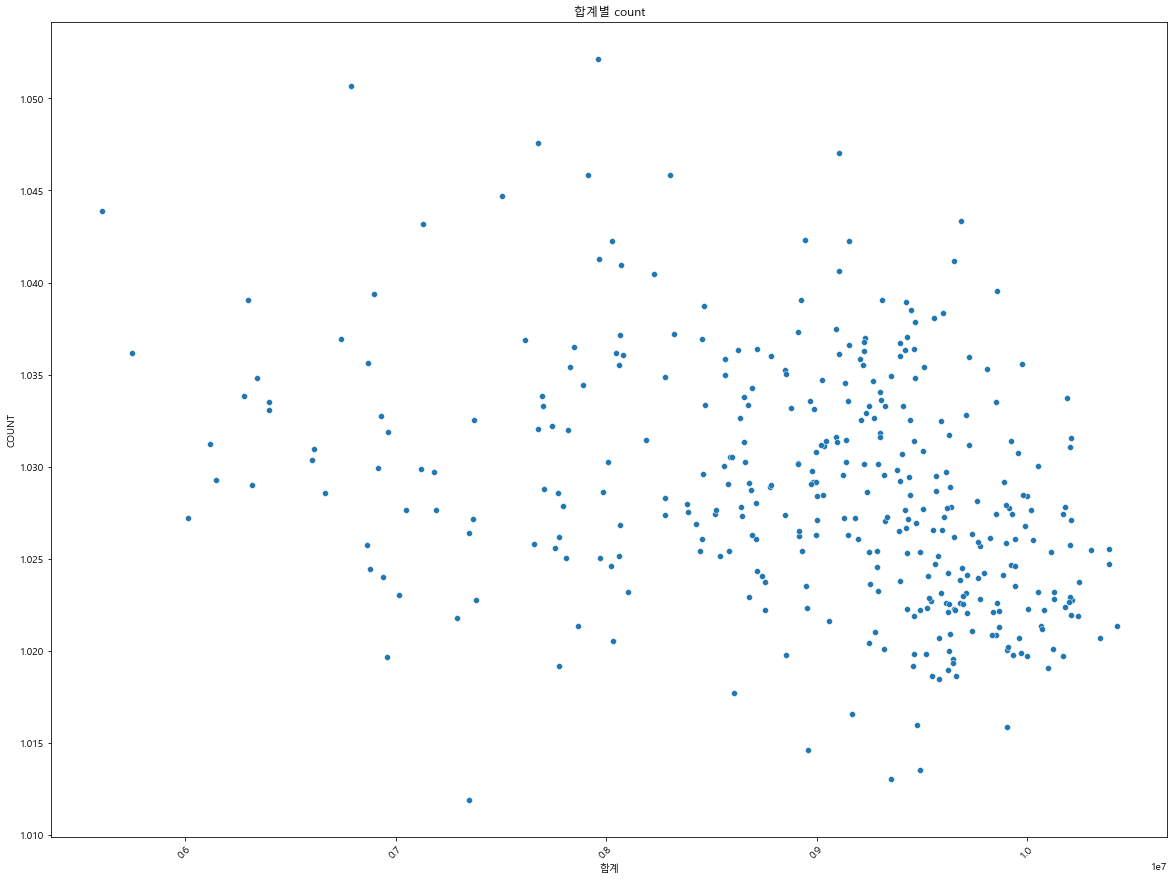

In [44]:
#스케일링 x
f, axs = plt.subplots(1,1, figsize = (20,15))
sns.scatterplot(data = df_moraficm, x = '합계',y = 'COUNT',estimator =len, palette="deep")
plt.xticks(rotation =45)
plt.title('합계별 count')
plt.show()

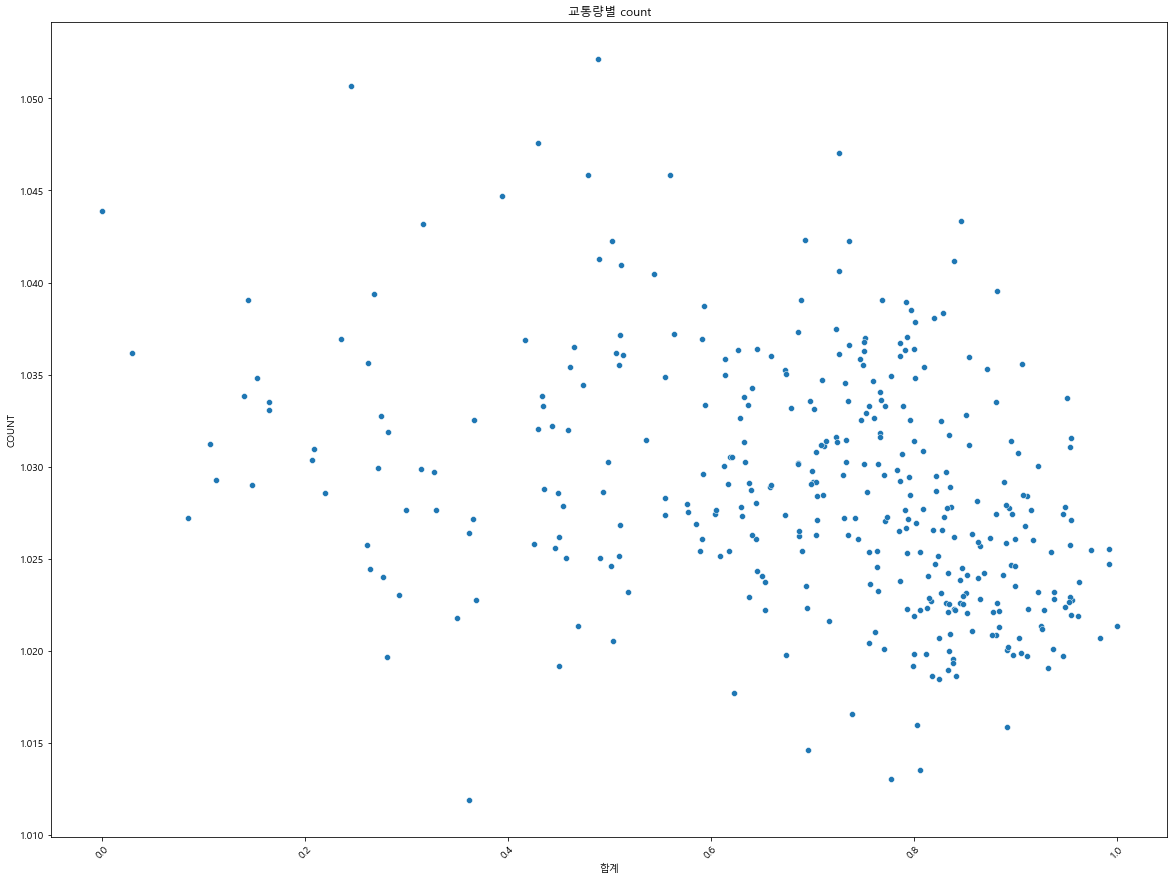

In [42]:
#스케일링 on
f, axs = plt.subplots(1,1, figsize = (20,15))
sns.scatterplot(data = df_modura2, x = '합계',y = 'COUNT',estimator =len)
plt.xticks(rotation =45)
plt.title('교통량별 count')
plt.show()

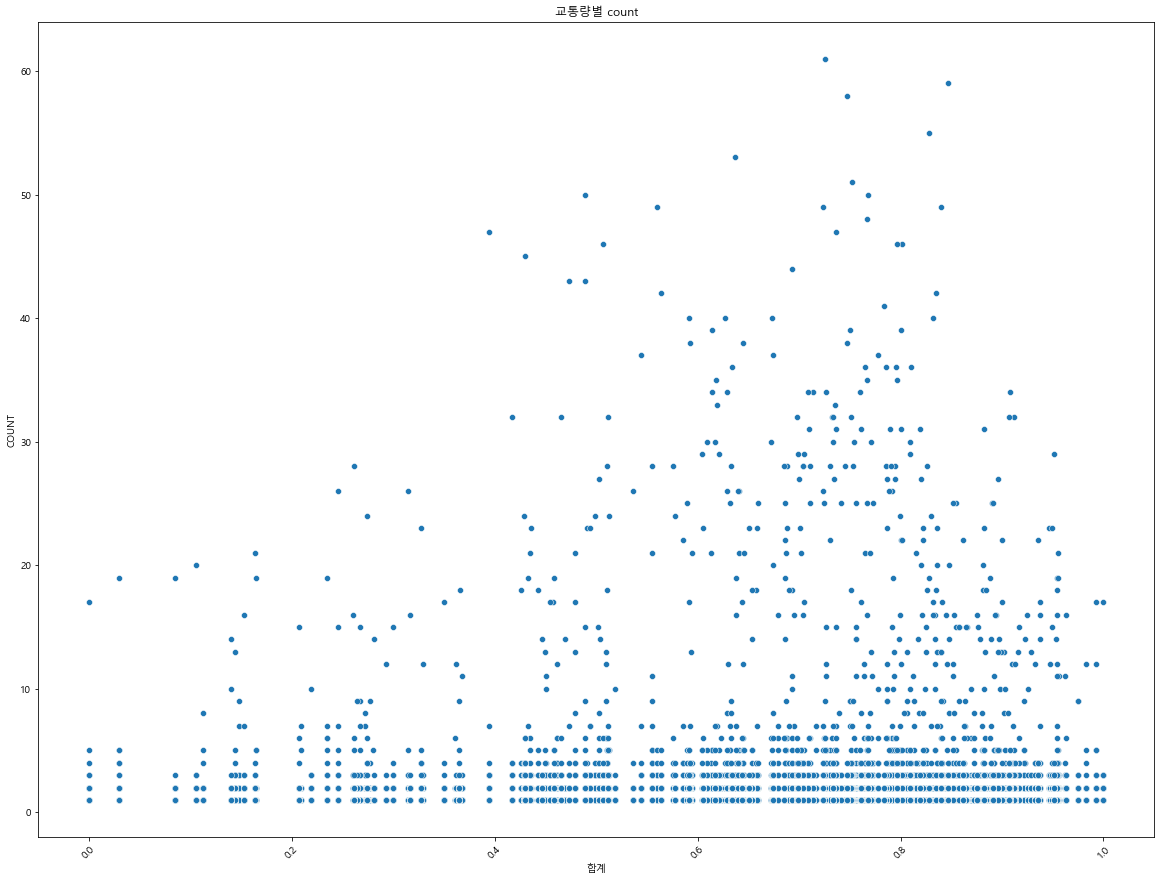

In [43]:
#스케일링 on ndata(해강님ver)
f, axs = plt.subplots(1,1, figsize = (20,15))
sns.scatterplot(data = ndata, x = '합계',y = 'COUNT',estimator =len)
plt.xticks(rotation =45)
plt.title('교통량별 count')
plt.show()